## Imports

In [41]:
pip install pyccel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [51]:
def solve_2d_burger_pure(u, un, v, vn, nt, dt, dx, dy, nu):
    
    
    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #fill the update of u and v
    for n in range(nt+ 1 ):
      ##loop across number of time steps
      for j in range(row):
        for i in range(col):
          un[j][i] = u[j][i]
          vn[j][i] = v[j][i]
        
      for j in range(2, row):
        for i in range(2, col):
          u[j-1, i-1] = (un[i-1, j-1] -
                                 dt / dx * un[j-1, i-1] * 
                                 (un[j-1, i-1] - un[j-1, i-2]) - 
                                 dt / dy * vn[j-1, i-1] * 
                                 (un[j-1, i-1] - un[j-2, i-1]) + 
                                 nu * dt / dx**2 * 
                                 (un[j-1, i] - 2 * un[j-1, i-1] + un[j-1, i-2]) + 
                                 nu * dt / dy**2 * 
                                 (un[j, i-1] - 2 * un[j-1, i-1] + un[j-2, i-1]))
                
          v[j-1, i-1] = (vn[j-1, i-1] - 
                                 dt / dx * un[j-1, i-1] *
                                 (vn[j-1, i-1] - vn[j-1, i-2]) -
                                 dt / dy * vn[j-1, i-1] * 
                                (vn[j-1, i-1] - vn[j-2, i-1]) + 
                                 nu * dt / dx**2 * 
                                 (vn[j-1, i] - 2 * vn[j-1, i-1] + vn[j-1, i-2]) +
                                 nu * dt / dy**2 *
                                 (vn[j, i-1] - 2 * vn[j-1, i-1] + vn[j-2, i-1]))
        
      u[0, :] = 1
      u[-1, :] = 1
      u[:, 0] = 1
      u[:, -1] = 1
      v[0, :] = 1
      v[-1, :] = 1
      v[:, 0] = 1
      v[:, -1] = 1
        
    return 0

## Numba accelerator

In [52]:
@njit(fastmath=True)
def solve_2d_burger_numba(u, un, v, vn, nt, dt, dx, dy, nu):
    
    
    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #fill the update of u and v
    for n in range(nt+ 1):
      ##loop across number of time steps
      for j in range(row):
        for i in range(col):
          un[j][i] = u[j][i]
          vn[j][i] = v[j][i]
        
      for j in range(2, row):
        for i in range(2, col):
          u[j-1, i-1] = (un[i-1, j-1] -
                                 dt / dx * un[j-1, i-1] * 
                                 (un[j-1, i-1] - un[j-1, i-2]) - 
                                 dt / dy * vn[j-1, i-1] * 
                                 (un[j-1, i-1] - un[j-2, i-1]) + 
                                 nu * dt / dx**2 * 
                                 (un[j-1, i] - 2 * un[j-1, i-1] + un[j-1, i-2]) + 
                                 nu * dt / dy**2 * 
                                 (un[j, i-1] - 2 * un[j-1, i-1] + un[j-2, i-1]))
                
          v[j-1, i-1] = (vn[j-1, i-1] - 
                                 dt / dx * un[j-1, i-1] *
                                 (vn[j-1, i-1] - vn[j-1, i-2]) -
                                 dt / dy * vn[j-1, i-1] * 
                                (vn[j-1, i-1] - vn[j-2, i-1]) + 
                                 nu * dt / dx**2 * 
                                 (vn[j-1, i] - 2 * vn[j-1, i-1] + vn[j-1, i-2]) +
                                 nu * dt / dy**2 *
                                 (vn[j, i-1] - 2 * vn[j-1, i-1] + vn[j-2, i-1]))
        
      u[0, :] = 1
      u[-1, :] = 1
      u[:, 0] = 1
      u[:, -1] = 1
      v[0, :] = 1
      v[-1, :] = 1
      v[:, 0] = 1
      v[:, -1] = 1
        
        
    return 0

## Pyccel accelerator

In [53]:
@types('float[:,:]','float[:,:]','float[:,:]','float[:,:]', 'int','float', 'float', 'float', 'float')
def solve_2d_burger_pyccel(u, un, v, vn, nt, dt, dx, dy, nu):
    
    
    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #fill the update of u and v
    for n in range(nt+ 1 ):
      ##loop across number of time steps
      for j in range(row):
        for i in range(col):
          un[j][i] = u[j][i]
          vn[j][i] = v[j][i]
        
      for j in range(2, row):
        for i in range(2, col):
          u[j-1, i-1] = (un[i-1, j-1] -
                                 dt / dx * un[j-1, i-1] * 
                                 (un[j-1, i-1] - un[j-1, i-2]) - 
                                 dt / dy * vn[j-1, i-1] * 
                                 (un[j-1, i-1] - un[j-2, i-1]) + 
                                 nu * dt / dx**2 * 
                                 (un[j-1, i] - 2 * un[j-1, i-1] + un[j-1, i-2]) + 
                                 nu * dt / dy**2 * 
                                 (un[j, i-1] - 2 * un[j-1, i-1] + un[j-2, i-1]))
                
          v[j-1, i-1] = (vn[j-1, i-1] - 
                                 dt / dx * un[j-1, i-1] *
                                 (vn[j-1, i-1] - vn[j-1, i-2]) -
                                 dt / dy * vn[j-1, i-1] * 
                                (vn[j-1, i-1] - vn[j-2, i-1]) + 
                                 nu * dt / dx**2 * 
                                 (vn[j-1, i] - 2 * vn[j-1, i-1] + vn[j-1, i-2]) +
                                 nu * dt / dy**2 *
                                 (vn[j, i-1] - 2 * vn[j-1, i-1] + vn[j-2, i-1]))
        
      u[0, :] = 1
      u[-1, :] = 1
      u[:, 0] = 1
      u[:, -1] = 1
      v[0, :] = 1
      v[-1, :] = 1
      v[:, 0] = 1
      v[:, -1] = 1
        
        
    return 0

## Inputs

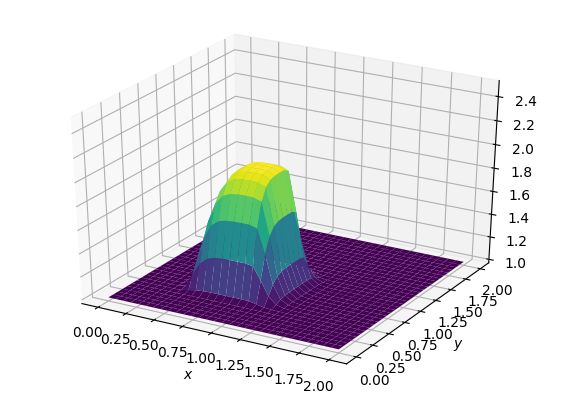

In [62]:
###variable declarations
nx = 31
ny = 31
nt = 120
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .0009
nu = 0.01
dt = sigma * dx * dy / nu


x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx))  # create a 1xn vector of 1's
v = np.ones((ny, nx))
un = np.ones((ny, nx)) 
vn = np.ones((ny, nx))

solve_2d_burger_pure(u, un, v, vn, nt, dt, dx, dy, nu)

X, Y = np.meshgrid(x, y)
fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, u, rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=True)
ax.set_zlim(1, 2.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

## Call Funtions

### Pure function

In [63]:
%timeit solve_2d_burger_pure(u, un, v, vn, nt, dt, dx, dy, nu)

1 loop, best of 5: 1.02 s per loop


### Function with numba accelerator

In [64]:
%timeit solve_2d_burger_numba(u, un, v, vn, nt, dt, dx, dy, nu)

The slowest run took 918.42 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 1.38 ms per loop


### Function with pyccel accelerator

In [65]:
solve_2d_burger_f90 = epyccel(solve_2d_burger_pyccel)

In [66]:
%timeit solve_2d_burger_f90(u, un, v, vn, nt, dt, dx, dy, nu)

1000 loops, best of 5: 746 µs per loop
